In [1]:
using Oceananigans
using CairoMakie
using JLD2
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian

[ Info: Oceananigans will use 4 threads


[ Info: Created a front state with Riₘᵢₙ = 2.002232638592509, Roₘᵢₙ = -0.48710514788387305, Roₘₐₓ = 0.45331707138052063


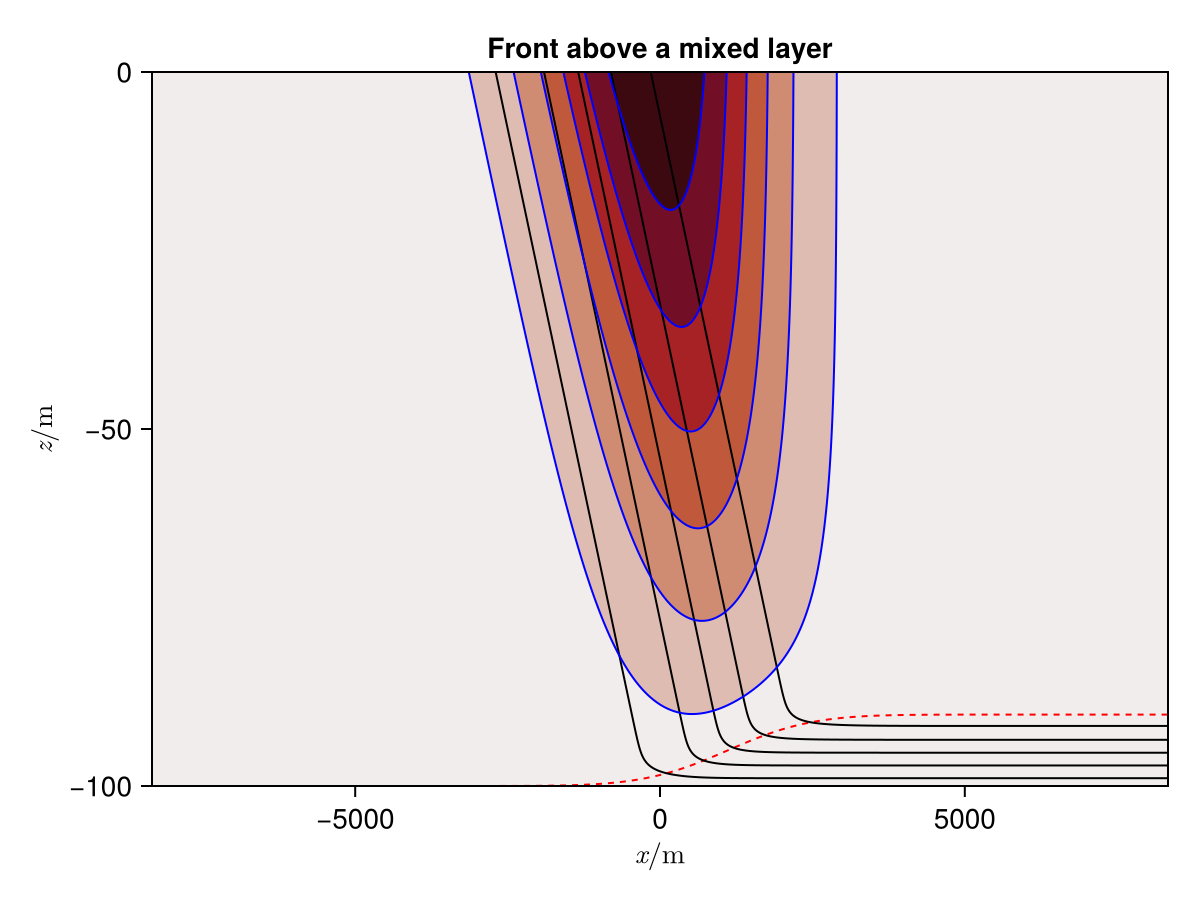

In [72]:
include("../src-fronts/parameters.jl")
include("../src-fronts/base_state.jl")
g(x) = log(1 + exp(x))
sp = create_simulation_parameters(; Ri=2, Ro=0.6, Q=100)
(; xs, zs, u, v, w, b) = get_base_state(sp)

ζ = (circshift(v, (-1, 0)) - circshift(v, (1, 0))) ./ (circshift(xs, -1) - circshift(xs, 1))
N² = zeros(size(b))
N²[:, 2:end] = (b[:, 2:end] - b[:, 1:end-1]) ./ (reshape(zs[2:end], 1, 499) - reshape(zs[1:end-1], 1, 499))
S = zeros(size(v))
S[:, 2:end] = (v[:, 2:end] - v[:, 1:end-1]) ./ (reshape(zs[2:end], 1, 499) - reshape(zs[1:end-1], 1, 499))
M² = (circshift(b, (-1, 0)) - circshift(b, (1, 0))) ./ (circshift(xs, -1) - circshift(xs, 1))
M²[1, :] .= M²[2, :]
M²[end, :] .= M²[end-1, :]

q = (ζ .+ sp.f) .* N² .- S .* M²

v_approx(x, z) = let h(x) = sp.H * γ(x/sp.ℓ, sp.δ)
    let x = x + sp.a*sp.H/2
        z₀(x, n) = n <= 0 ? n : h(x + sp.a*z₀(x, n-1))
    (1-sp.ε) * sp.N₀² * (h(x+sp.a*z) - h(x+sp.a*z₀(x, 10))) / (sp.f * sp.a)
    end
end

Ri = N² ./ S.^2
Ro = ζ ./ sp.f

Riₘᵢₙ = minimum(Ri[:, 2:end])
Roₘᵢₙ = minimum(Ro)
Roₘₐₓ = maximum(Ro)

@info "Created a front state with Riₘᵢₙ = $Riₘᵢₙ, Roₘᵢₙ = $Roₘᵢₙ, Roₘₐₓ = $Roₘₐₓ"

fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"x / \text{m}", ylabel=L"z / \text{m}", title="Front above a mixed layer", limits=(xs[1], xs[end], -sp.H, 0))
h(x, z) = z - sp.H * γ(x/sp.ℓ, 0.1)

let a = [v_approx(x, z) for x in xs, z in zs]
    contourf!(ax, xs, zs, a; levels=range(-maximum(abs, a), maximum(abs, a), 14), colormap=:balance)
end
#heatmap!(ax, xs, zs, q; colormap=:balance, colorrange=(-sp.f * sp.N₀²/10, sp.f * sp.N₀²/10))
contour!(ax, xs, zs, q; levels=[0], color=:blue)
contour!(ax, xs, zs, (x, z)->h(x + sp.a * (z+sp.H/2), z); color=:red, levels=[0], linestyle=:dash)
contour!(ax, xs, zs, b; color=:black)
let a = v
    contour!(ax, xs, zs, a; levels=range(-maximum(abs, a), maximum(abs, a), 14), color=:blue)
end
fig

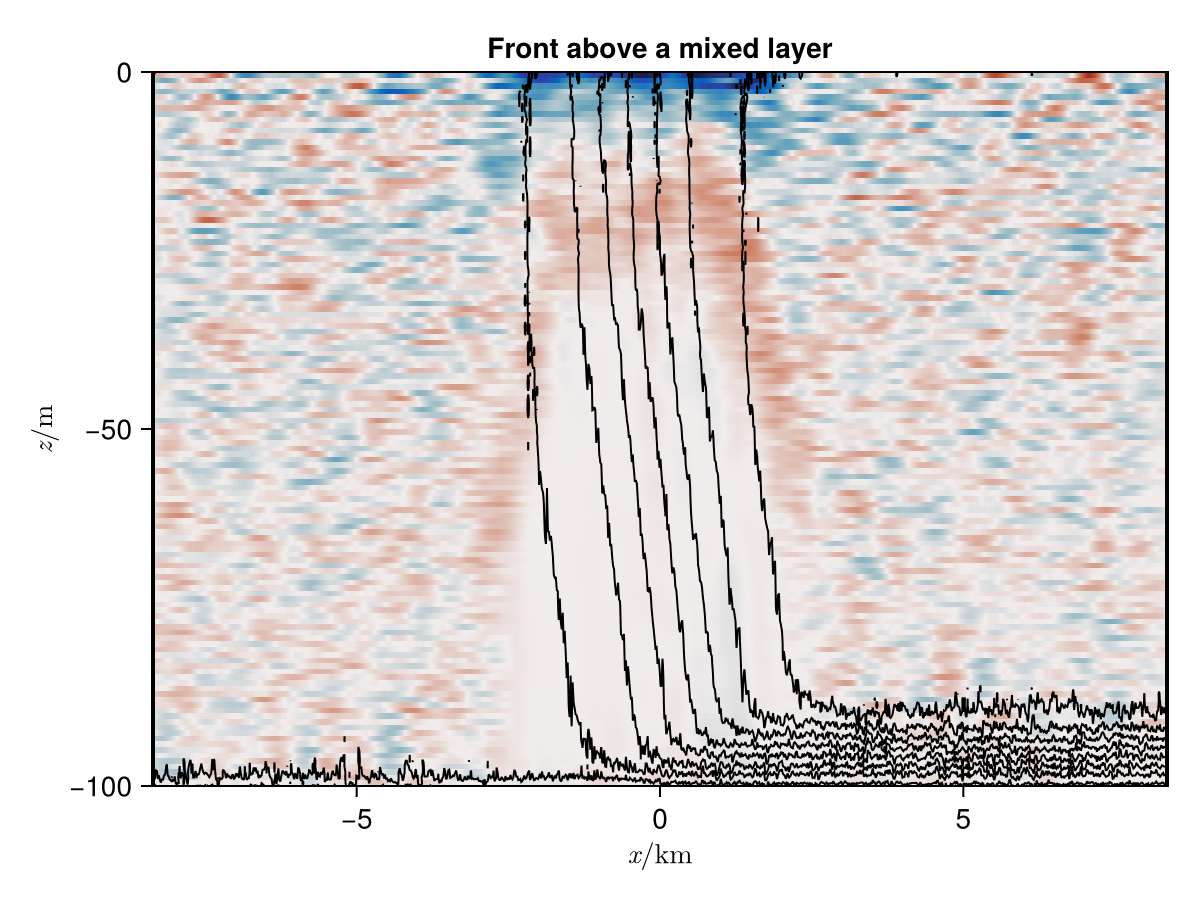

In [55]:
# Print simulation outputs
# Get a state of simulation
n = 101
foldername = "../../scratch/Project/front-init-test-2"

sp = jldopen("$foldername/parameters.jld2") do file
    NamedTuple(map(keys(file)) do k
        Pair(Symbol(k), file[k])
            end)
end
filename = "$foldername/initialisation.jld2"
t, xs, ys, zs, u, v, w, b, φ = jldopen(filename) do file
    frames = keys(file["timeseries/t"])
    ts = [file["timeseries/t/$frame"] for frame in frames]
    frame = frames[n]
    xs = file["grid/xᶜᵃᵃ"]
    ys = file["grid/yᵃᶜᵃ"]
    zs = file["grid/zᵃᵃᶜ"]
    u = (file["timeseries/u/$frame"][1:end-1, :, :] .+ file["timeseries/u/$frame"][2:end, :, :]) ./ 2
    v = (circshift(file["timeseries/v/$frame"], (0, -1, 0)) .+ circshift(file["timeseries/v/$frame"], (0, 1, 0))) ./ 2
    w = (file["timeseries/w/$frame"][:, :, 1:end-1] .+ file["timeseries/w/$frame"][:, :, 2:end]) ./ 2
    b = file["timeseries/b/$frame"]
    φ = file["timeseries/φ/$frame"]
    ts[n], xs, ys, zs, u, v, w, b, φ
    end;
fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"x / \text{km}", ylabel=L"z / \text{m}", title="Front above a mixed layer", limits=(xs[1]/1000, xs[end]/1000, -sp.H, 0))
#field = mean((v .- mean(v; dims=2)) .* (w .- mean(w; dims=2)); dims=2)[:, 1, :]
#ψ = mean(cumsum(u; dims=3) * (zs[2]-zs[1]); dims=2)[:, 1, :]
b_levels = range(minimum(mean(b[4:end-3, :, 4:end-3]; dims=2)), maximum(mean(b[4:end-3, :, 4:end-3]; dims=2)), 10)
#field = field - imfilter(field, gaussian((10, 0)))
field = mean(u; dims=2)[:, 1, :]
field = imfilter(field, gaussian((10, 0)))
#field = circshift(mean(φ; dims=2)[:, 1, :], (-1, 0)) .- circshift(mean(φ; dims=2)[:, 1, :], (1, 0))
heatmap!(ax, xs / 1000, zs, field; colormap=:balance, colorrange=(-maximum(abs, field), maximum(abs, field)))
contour!(ax, xs / 1000, zs, mean(b; dims=2)[:, 1, :]; color=:black, levels=b_levels)
#contour!(ax, xs / 1000, zs, mean(v; dims=2)[:, 1, :]; color=:blue, levels=5)
#contour!(ax, xs / 1000, zs, ψ; colormap=:balance, colorrange=(-maximum(abs, ψ), maximum(abs, ψ)), levels=3)

fig

In [10]:
v = mean(v; dims=2)[:, 1, :]
shear = ((v[:, 1:end-2] - v[:, 3:end]) / (zs[3]-zs[1]))
shear = imfilter(shear, gaussian((3, 1)))[4:end-3, 3:end-2]
field = imfilter(field, gaussian((3, 1)))[4:end-3, 4:end-3];

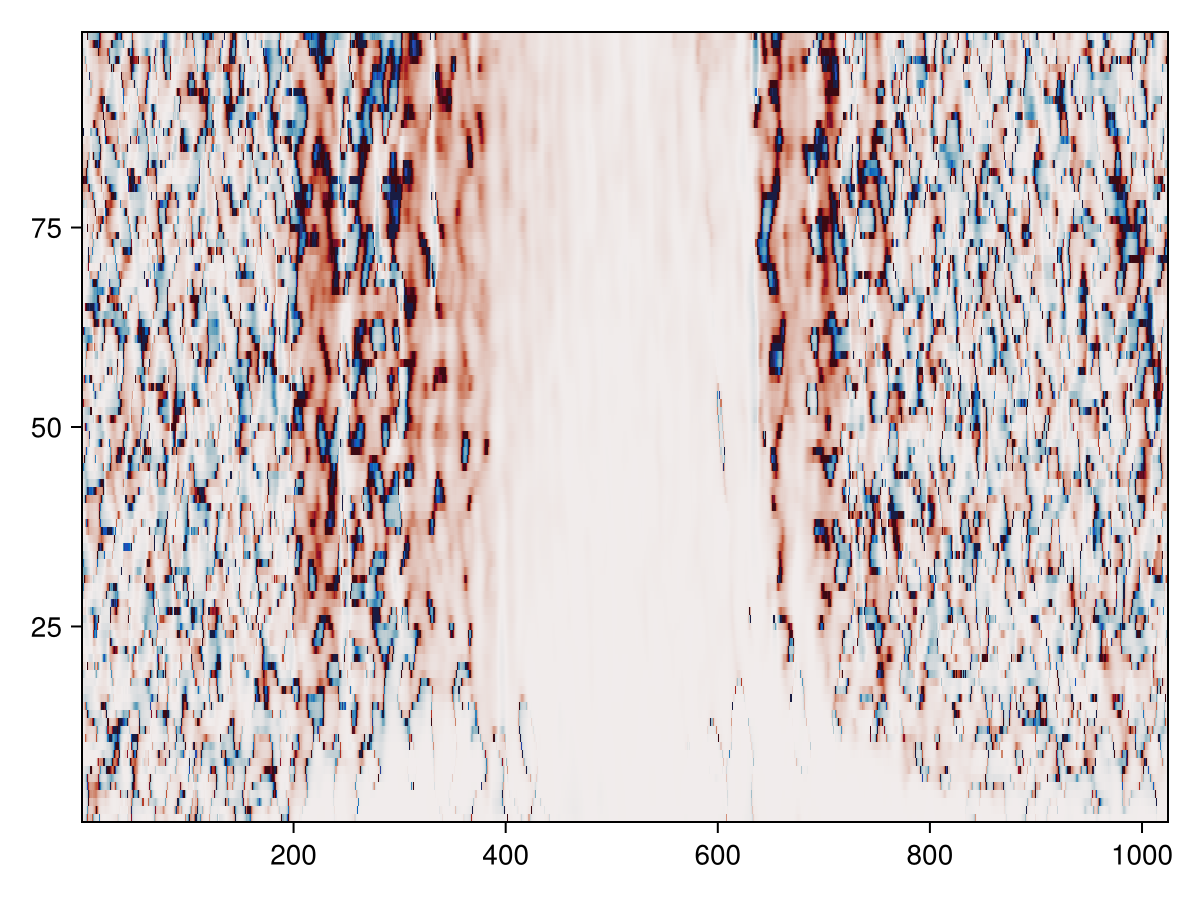

In [13]:
heatmap(field[:, 10:end-20] ./ shear[:, 10:end-20]; colormap=:balance, colorrange=(-0.1, 0.1))

In [ ]:
ts, xs, zs, u_long, v_long, w_long, b_long = jldopen(filename) do file
    frames = keys(file["timeseries/t"])
    ts = [file["timeseries/t/$frame"] for frame in frames]
    frame = frames[n]
    xs = file["grid/xᶜᵃᵃ"][4:end-3]
    zs = file["grid/zᵃᵃᶜ"][4:end-3]
    
    u = [mean(file["timeseries/u/$frame"][:, :, end-20]; dims=2)[4:end-3, 1] for frame in frames]
    u = [u[j][i] for i in 1:length(xs), j in 1:length(frames)]
    v = [mean(file["timeseries/v/$frame"][:, :, end-20]; dims=2)[4:end-3, 1] for frame in frames]
    v = [v[j][i] for i in 1:length(xs), j in 1:length(frames)]
    w = [mean(file["timeseries/w/$frame"][:, :, end-20]; dims=2)[4:end-3, 1] for frame in frames]
    w = [w[j][i] for i in 1:length(xs), j in 1:length(frausines)]
    b = [mean(file["timeseries/b/$frame"][:, :, end-20]; dims=2)[4:end-3, 1] for frame in frames]
    b = [b[j][i] for i in 1:length(xs), j in 1:length(frames)]
    ts, xs, zs, u, v, w, b
    end;

LoadError: InterruptException:

In [19]:
fig = Figure(; size=(1100, 500))
ax = Axis(fig[1, 1]; title = "Across-front velocity after cooling switched on, Ri=0, Q=10Wm⁻²", xlabel="x / km", ylabel="ft / 2π", limits=(nothing, (0, nothing)))
field = u_long[:, :, end]
heatmap!(ax, xs / 1000, ts * sp.f / (2π), field; colormap=:balance, colorrange=(-maximum(abs, field), maximum(abs, field)))
contour!(ax, xs / 1000, ts * sp.f / (2π), b_long[4:end-3, :, end-5]; color=:black, levels=50)

ax = Axis(fig[1, 2]; title = "Vertical velocity after cooling switched on, Ri=0, Q=10Wm⁻², coarse-grained", xlabel="x / km", ylabel="ft / 2π", limits=(nothing, (0, nothing)))
field = imfilter(w[:, :, end], gaussian((10, 0)), "circular")
heatmap!(ax, xs / 1000, ts * sp.f / (2π), field; colormap=:balance, colorrange=(-maximum(abs, field), maximum(abs, field)))
contour!(ax, xs / 1000, ts * sp.f / (2π), b[4:end-3, :, end-5]; color=:black, levels=50)
fig

LoadError: UndefVarError: `ts` not defined